# Dual-Model Analysis (Custom Objectives)

이 노트북에서는 **Custom Objectives (IC & Quantile)**로 학습된 모델의 **OOF 성능**을 검증합니다.

## 변경 사항
1.  **Return Model:** RMSE 대신 **Correlation (IC)**를 기준으로 Early Stopping. (순위 예측 최적화)
2.  **Risk Model:** MAE 대신 **Quantile Regression (alpha=0.75)** 사용. (위험 과소평가 방지)

## 검증 포인트
1.  **Return Model:** IC가 안정적으로 양수인가?
2.  **Risk Model:** 예측된 Risk가 실제 Risk(Abs Return)의 상단을 잘 커버하는가? (Quantile 효과 확인)
3.  **Strategy:** 하락장에서 방어력이 향상되었는가?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

# 프로젝트 루트 경로 추가
sys.path.append(str(Path.cwd().parent))

# 시각화 설정
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline


## 1. OOF 데이터 로드


In [2]:
# OOF 데이터 로드
oof_path = Path("../results/oof_predictions.csv")
if not oof_path.exists():
    raise FileNotFoundError("OOF prediction file not found. Please run the pipeline first.")

df = pd.read_csv(oof_path)
print(f"✅ OOF Data loaded: {df.shape}")
df.head()


✅ OOF Data loaded: (2500, 5)


,date_id,actual_return,pred_return,pred_risk,allocation
0,2020,0.019660,-0.000241,0.021327,0.000000
1,2021,0.015686,-0.004307,0.008473,0.000000
2,2022,-0.000644,-0.001251,0.007311,0.065291
3,2023,0.005151,-0.003159,0.012275,0.000000
4,2024,0.002243,-0.000954,0.009454,0.076167


## 2. Return Model 검증 (IC Check)


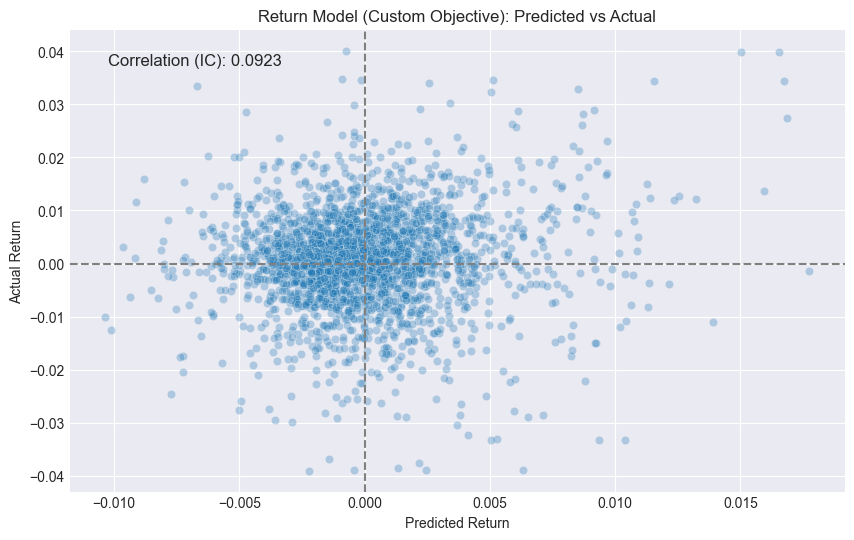

In [3]:
# Scatter Plot: Predicted vs Actual Return
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pred_return', y='actual_return', alpha=0.3)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title('Return Model (Custom Objective): Predicted vs Actual')
plt.xlabel('Predicted Return')
plt.ylabel('Actual Return')

# 상관계수 계산
corr = df['pred_return'].corr(df['actual_return'])
plt.text(0.05, 0.95, f'Correlation (IC): {corr:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.show()


## 3. Risk Model 검증 (Quantile Check)
Quantile Regression을 사용했으므로, 예측값(주황색)이 실제값(파란색 점)보다 **대체로 위에** 있어야 합니다. (Safety Buffer)

- Risk Model (Quantile Check): 그래프에서 주황색 점(예측값)들이 파란색 점(실제값)보다 대체로 위쪽에 위치하는지 확인하세요. 이는 모델이 위험을 과소평가하지 않으려고 "안전 마진"을 두고 있다는 뜻입니다.

- Under-estimation Rate: 그래프 상단에 표시된 수치가 25% 미만이면 의도한 대로(alpha=0.75) 작동한 것입니다.

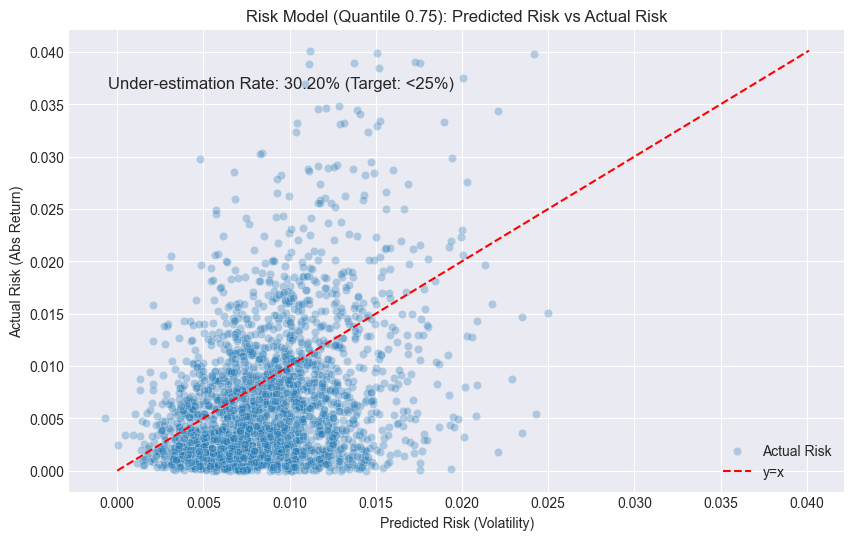

In [4]:
# Scatter Plot: Predicted Risk vs Actual Risk
df['actual_risk'] = df['actual_return'].abs()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pred_risk', y='actual_risk', alpha=0.3, label='Actual Risk')

# y=x line (Reference)
max_val = max(df['pred_risk'].max(), df['actual_risk'].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='y=x')

plt.title('Risk Model (Quantile 0.75): Predicted Risk vs Actual Risk')
plt.xlabel('Predicted Risk (Volatility)')
plt.ylabel('Actual Risk (Abs Return)')
plt.legend()

# Under-estimation Rate Check
under_estimation = (df['actual_risk'] > df['pred_risk']).mean()
plt.text(0.05, 0.90, f'Under-estimation Rate: {under_estimation:.2%} (Target: <25%)', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.show()


## 4. Strategy Simulation


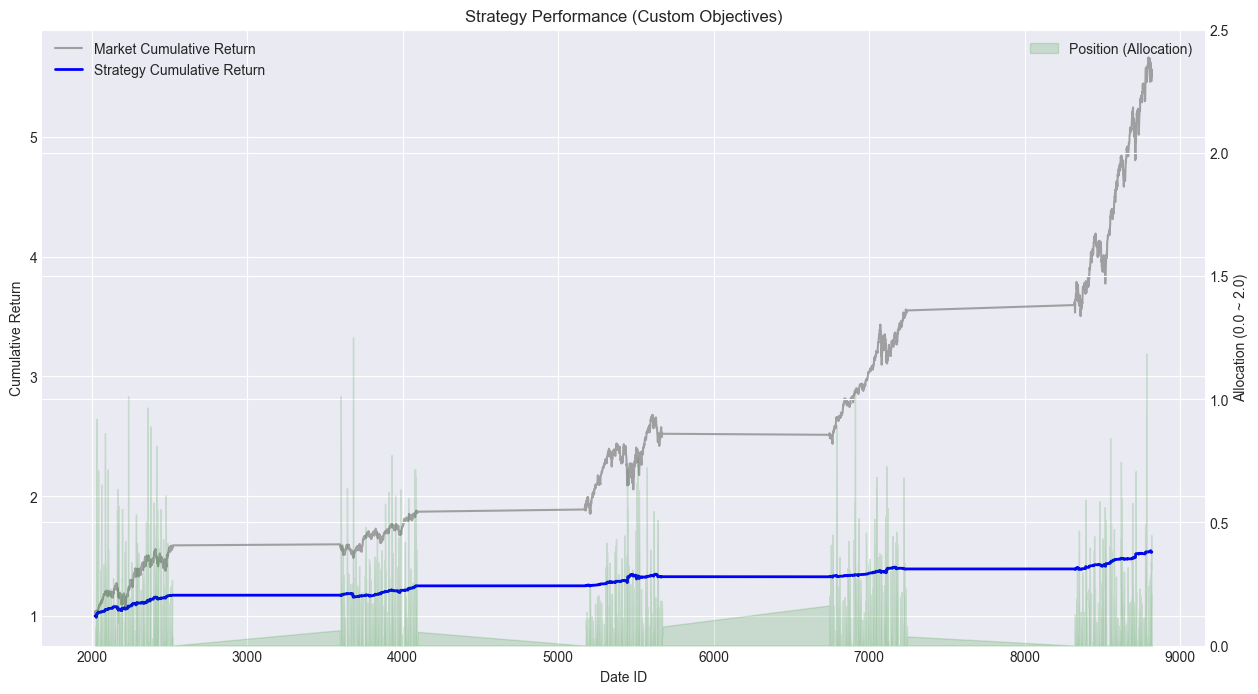

In [5]:
# 누적 수익률 계산
df['cum_market_return'] = (1 + df['actual_return']).cumprod()
df['strategy_return'] = df['allocation'] * df['actual_return']
df['cum_strategy_return'] = (1 + df['strategy_return']).cumprod()

# 시각화
fig, ax1 = plt.subplots(figsize=(15, 8))

# 시장 누적 수익률 (왼쪽 축)
ax1.plot(df['date_id'], df['cum_market_return'], label='Market Cumulative Return', color='gray', alpha=0.7)
ax1.plot(df['date_id'], df['cum_strategy_return'], label='Strategy Cumulative Return', color='blue', linewidth=2)
ax1.set_xlabel('Date ID')
ax1.set_ylabel('Cumulative Return')
ax1.legend(loc='upper left')

# Allocation (오른쪽 축)
ax2 = ax1.twinx()
ax2.fill_between(df['date_id'], df['allocation'], color='green', alpha=0.15, label='Position (Allocation)')
ax2.set_ylabel('Allocation (0.0 ~ 2.0)')
ax2.set_ylim(0, 2.5) # 여백 확보
ax2.legend(loc='upper right')

plt.title('Strategy Performance (Custom Objectives)')
plt.show()
